Тут мы пробуем спиздить данные с avto.ru и как-то их проанализировать.
Нас интересуют данные по машинам Ford Focus, II поколение (рестайлинг), коробка автомат, по всем регионам.

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.dates import HourLocator, DayLocator, MonthLocator, YearLocator, DateFormatter
from matplotlib.pylab import rcParams
import numpy as np
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly

import plotly.graph_objs as go
import seaborn as sb
import folium
import json
import warnings                    # убираем ошибки из output 
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)
rcParams['figure.figsize'] = 15,6


In [9]:
offers = []
for i in range(1, 3):
    with open(f'/home/ivan/WORK/PYTHON/studying/scrapy_spiders/avtoru/responses/ford_focus/response_page_{i}.json') as f:
        d = json.load(f)['offers']
        offers.extend(d)
df = pd.DataFrame(offers)
df.set_index(pd.Index(range(df.shape[0])))
df['owners_number'] = df.documents.apply(lambda x: x['owners_number'])
df['pts_original'] = df.documents.apply(lambda x: x['pts'])
df['custom_cleared'] = df.documents.apply(lambda x: x['custom_cleared'])
df['year'] = df.documents.apply(lambda x: x['year'])
# df['tax_by_year'] = df.owner_expenses.apply(lambda x: json.load(x)['transport_tax'])
# df['tax_by_year'] = df.owner_expenses.apply(lambda x: x['transport_tax']['tax_by_year'])
df['horse_power'] = df.vehicle_info.apply(lambda x: x['tech_param']['power'])
df['seller_coords'] = df.seller.apply(lambda x: (x['location']['coord']['latitude'], 
                                                 x['location']['coord']['longitude']))
df.drop(df[df.price_info == {}].index, axis=0, inplace=True)
df['price'] = df.price_info.apply(lambda x: x['price'])
df['state_mileage'] = df.state.apply(lambda x: x['mileage'])
df['state_not_beaten'] = df.state.apply(lambda x: x['state_not_beaten'])
useless_columns = ['documents', 'is_favorite', 'old_category_id', 'category', 'delivery_info', 'tags', 
                   'counters', 'grouping_info', 'hash', 'id', 'recall_info', 'saleId', 'sub_category',
                   'multiposting', 'discount_price', 'dealer_credit_config', 'soldMinutes',
                   'discount_options', 'section', 'services', 'shark_info', 'additional_info', 'price_info',
                   'owner_expenses', 'price_history', 'salon', 'seller', 'badges', 'service_prices']
for column in useless_columns:
    try:
        df.drop(column, axis=1, inplace=True)
    except KeyError:
        continue
df.head()

,availability,color_hex,description,seller_type,status,state,vehicle_info,lk_summary,owners_number,pts_original,custom_cleared,year,horse_power,seller_coords,price,state_mileage,state_not_beaten
0,IN_STOCK,0000CC,"Автомобиль в достойном состоянии. Чистый, куря...",PRIVATE,ACTIVE,"{'mileage': 186400, 'state_not_beaten': True, ...","{'configuration': {'id': '2306701', 'body_type...","2.0 AT (145 л.с.), седан, передний, бензин",3,ORIGINAL,True,2009,145,"(55.76226, 37.774734)",385000,186400,True
1,IN_STOCK,97948F,Бодрый надежный автомобиль. 2 комплекта резины...,PRIVATE,ACTIVE,"{'damages': [{'car_part': 'FRONT_LEFT_DOOR', '...","{'configuration': {'id': '2306701', 'body_type...","2.0 AT (145 л.с.), седан, передний, бензин",2,ORIGINAL,True,2009,145,"(59.220497, 39.891521)",420000,153000,True
2,IN_STOCK,97948F,- выгода 60 000 рублей при покупке авто в Trad...,COMMERCIAL,ACTIVE,"{'mileage': 119000, 'state_not_beaten': True, ...","{'configuration': {'id': '2306701', 'body_type...","2.0 AT (145 л.с.), седан, передний, бензин",3,ORIGINAL,True,2010,145,"(55.594612, 37.599129)",399000,119000,True
3,IN_STOCK,97948F,Представляем Вашему вниманию автомобиль Ford F...,COMMERCIAL,ACTIVE,"{'mileage': 189196, 'state_not_beaten': True, ...","{'configuration': {'id': '2306701', 'body_type...","2.0 AT (145 л.с.), седан, передний, бензин",1,ORIGINAL,True,2009,145,"(55.617271, 37.715687)",415000,189196,True
4,IN_STOCK,040001,Комплектация «Comfort»:\n• Антиблокировочная с...,COMMERCIAL,ACTIVE,"{'mileage': 150000, 'state_not_beaten': True, ...","{'configuration': {'id': '2306701', 'body_type...","2.0 AT (145 л.с.), седан, передний, бензин",3,ORIGINAL,True,2008,145,"(60.002541, 30.306364)",355000,150000,True


In [10]:
df['description'][0]

'Автомобиль в достойном состоянии. Чистый, курящий салон. Двигатель, коробка работают без нареканий. Обслужен, ухожен вложений не требует. Хранится дома, в гараже. Срочная продажа. Торг.'

In [12]:
df.shape

(45, 17)

In [11]:
df['description'][38]

'Отличный автомобиль. Из салона выехал в 2011 г. Кожаный заводской салон.  Подогревы лобового, зеркал, передних кресел. Музыка Sony. Пробег родной. Фаркоп. Подогрев лобового стекла. Летняя резина Nokia на литье. Зимняя тоже Нокиа на литьё. Без дтп. Все стекла родные. Я хозяин. Перекурам не беспокоить. В салон не поставлю. В будни звонить с 17 до 22, в выходные с 10до 22. '

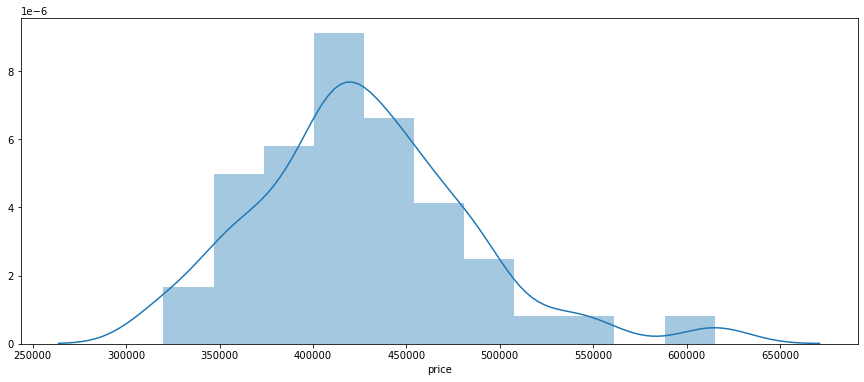

In [13]:
sb.distplot(df.price)

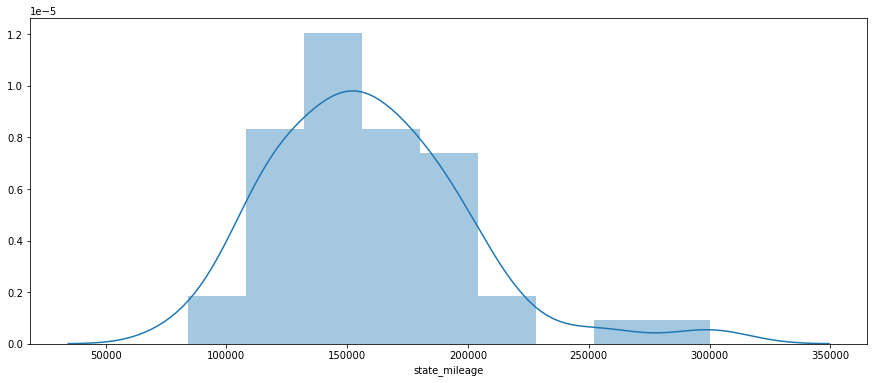

In [14]:
sb.distplot(df.state_mileage)

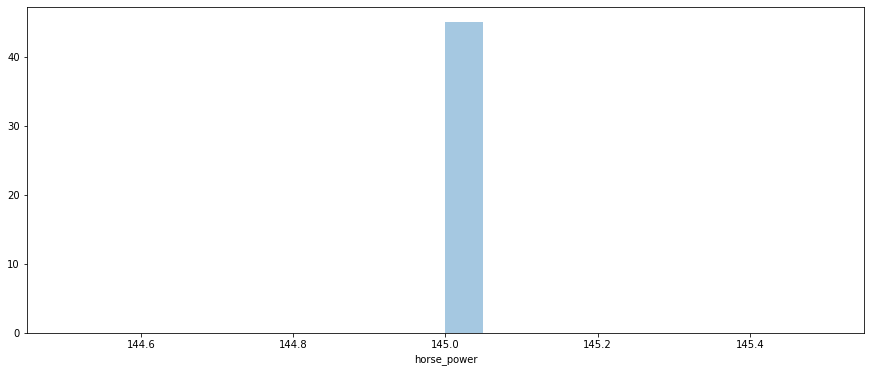

In [15]:
sb.distplot(df.horse_power, kde=False, bins=20)

In [16]:
m = folium.Map(location=[70.5236, 105.6750],
               zoom_start=3)

for i in df.index:
    folium.Circle( (df.seller_coords[i][0], df.seller_coords[i][1]), 
                  radius=70,
                  tooltip=df.price[i],
                  opacity=1,
                  fill=True,
                  
                  color=f'#{df.color_hex[i]}').add_to(m)
m